# Анализ тональности текста (Sentiment analysis). Анализ и подготовка данных

Используемый датасет: Токсичные комментарии (https://www.kaggle.com/datasets/blackmoon/russian-language-toxic-comments)

In [ ]:
!pip install -r requirements.txt

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords

import warnings


warnings.filterwarnings('ignore')
nltk.download('stopwords')

## Поверхностный анализ данных

In [2]:
train_data = pd.read_csv("./data/russian_toxic_comments.csv")

In [5]:
train_data.iloc[20:25]

,comment,toxic
20,"Ну, посмотрел я комментарии к твоим постам, пр...",1.0
21,"А где я это утверждал, чмоха? Опять спалились.\n",1.0
22,В обеих странах есть партия войны . И в обеих ...,1.0
23,и причем здесь чувство юмора? сам придумал - с...,1.0
24,Да какая агрессия. Тебя ткнули в твое же дерьм...,1.0


Датасет состоит из трех признаков:

* __comment__ - текст комментария (категориальный признак)
* __toxic__ - целевоой признак - оценка (0 - не является токсичным комментарием, 1 - является) (бинарный признак)

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14412 entries, 0 to 14411
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   comment  14412 non-null  object 
 1   toxic    14412 non-null  float64
dtypes: float64(1), object(1)
memory usage: 225.3+ KB


## Разведовательный анализ данных

Рассмотрим распределение образцов (записей в датасете) к значениям целевого признака (0 и 1)

<AxesSubplot:xlabel='toxic', ylabel='count'>

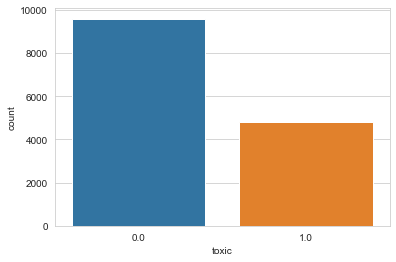

In [6]:
sns.countplot(train_data["toxic"])

Визуализируем следующую информацию:

* распределение длины комментария

* распределение количества слов в комментарии

<AxesSubplot:xlabel='word number', ylabel='Density'>

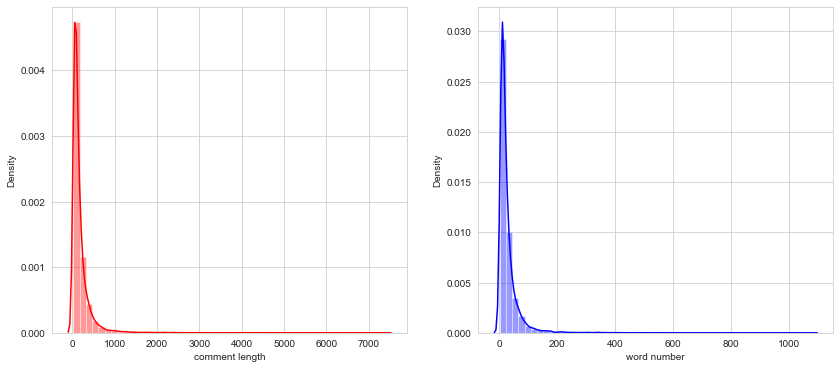

In [7]:
train_len = train_data["comment"].apply(len).rename("comment length")
train_count = train_data["comment"].apply(lambda row: len(str(row).split(" "))).rename("word number")

fig=plt.figure(figsize=(14,6))
fig.add_subplot(1,2,1)
sns.distplot(train_len,color='red')
fig.add_subplot(1,2,2)
sns.distplot(train_count,color='blue')

In [8]:
train_len.describe()

count    14412.000000
mean       176.525812
std        271.612376
min         21.000000
25%         57.000000
50%        101.000000
75%        197.000000
max       7404.000000
Name: comment length, dtype: float64

In [9]:
train_count.describe()

count    14412.000000
mean        27.946087
std         41.432195
min          1.000000
25%          9.000000
50%         16.000000
75%         32.000000
max       1078.000000
Name: word number, dtype: float64

Как можно видеть среди данных есть перевес в пользу нетоксичных комментариев, поэтому придется использовать в качестве метрики качества специальную для такого случая. К таким относится точность по __ROC-кривой__

Построим облако слов, которые часто встречаются в отзывах

In [10]:
from wordcloud import WordCloud, STOPWORDS

cloud = WordCloud(width=800, height=600, stopwords=set(STOPWORDS)).generate(" ".join(train_data["comment"]))

(-0.5, 799.5, 599.5, -0.5)

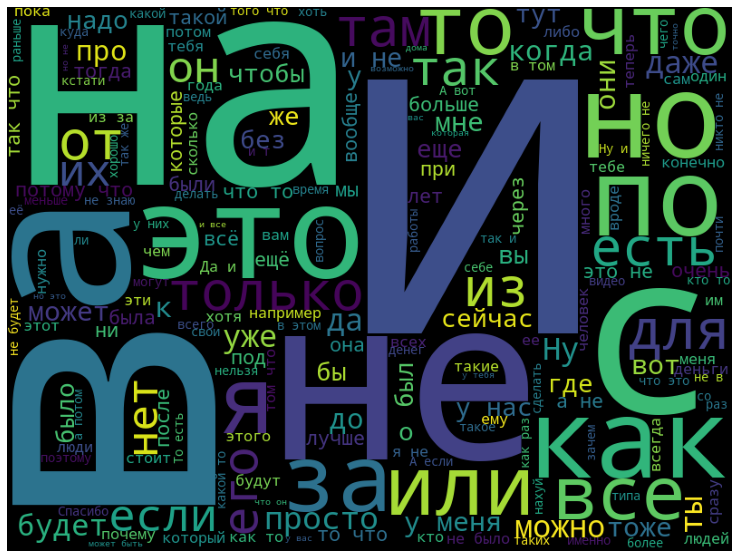

In [11]:
plt.figure(figsize=(16,10))
plt.imshow(cloud)
plt.axis('off')

Как можно видеть среди слов есть различные пробелы, стоп-слова и прочее.

Избавимся от них, а также сделаем полезные для обучения преобразования текста

In [12]:
from bs4 import BeautifulSoup
import re


def preprocess_text(raw: str) -> str:
    """Функция предобработки текстовых данных."""

    # удаляем HTML-теги
    text = BeautifulSoup(raw, "lxml").get_text()

    # удаляем не-слова (цифры, пробелы и прочее), заменяя их на пробел
    letters_only = re.sub("[^а-яА-Я]", " ", text)

    # переводим в нижний регистр
    lowercase_text = letters_only.lower()

    # удаляем стоп-слова (союзы, предлоги и прочее)
    no_stop_words = [word for word in lowercase_text.split() if word not in set(stopwords.words("russian"))]

    # объединяем получившееся в предложение
    return " ".join(no_stop_words)

In [13]:
clear_train = train_data.copy()
clear_train["comment"] = clear_train["comment"].apply(preprocess_text)

(-0.5, 799.5, 599.5, -0.5)

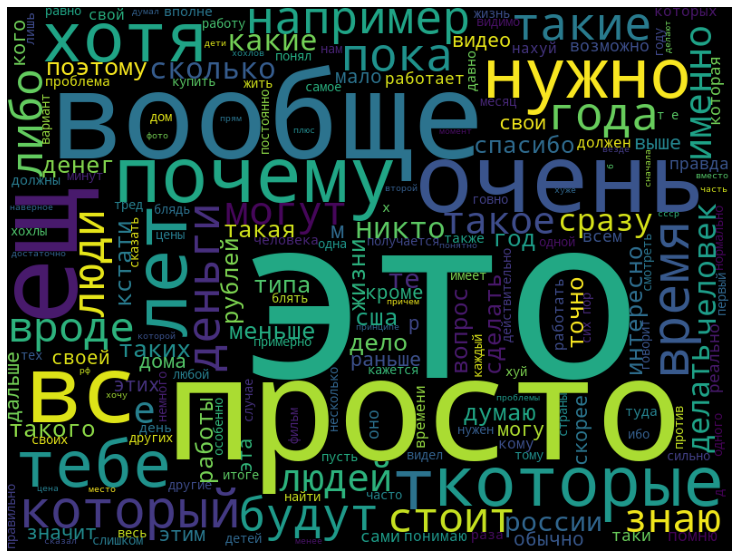

In [14]:
cloud = WordCloud(width=800, height=600, stopwords=set(STOPWORDS)).generate(" ".join(clear_train["comment"]))
plt.figure(figsize=(16,10))
plt.imshow(cloud)
plt.axis('off')

In [15]:
clear_train.to_csv("./data/clear_train_data.csv", index=False)